In [45]:
%matplotlib inline
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import BasisEmbedding, AmplitudeEmbedding, AngleEmbedding
from pennylane import QubitStateVector

n_qubits = 5
dev = qml.device('default.qubit', wires=n_qubits)
mpl.rcParams['figure.dpi'] = 75

# Quantum embedding (Квантовое представление)
- Что такое признаки (features)?
- Quantum feature map
- Основные типы представления

Quantum embedding -- это представление классических данных в виде параметров квантовой схемы-генератора. Состояние на выходе генератора зависит от заданных классических данных.

См. https://arxiv.org/pdf/2001.03622.pdf

Если рассматривать процесс гибридных вычислений в общем, то его можно описать такой схемой:

<img src="hybrid.jfif">

## Что такое признаки?
Признаки (features) -- это числовое представление особенностей объекта. То есть объекту сопоставляется некоторый числовой вектор, который отражает его уникальность. Например, если у нас есть кубы и шары двух разных цветов (синего и красного), то мы можем описать их с помощью двухмерного вектора признаков, если проведем сопоставление $\{0: "шар", 1: "куб"\}$, $\{0: "синий", 1: "красный"\}$. Красный шар будет иметь вектор признаков $\{0, 1\}$.

Помимо дискретных, могут быть непрерывные признаки, например угол поворота или координаты.

Раньше признаки разрабатывали вручную, сейчас зачастую они генерируются с помощью глубоких нейронных сетей.

## Quantum feature map
Quantum feature map -- это преобразование, действующее из пространства классических в пространство квантовых признаков.

## Основные типы представления
### Basis embedding
Классические данные -- битовые строки. Идет сопоставление между битовой строкой и базисным квантовым состоянием вида $"01010"\to |01010\rangle$. Для этого строится кодирующая квантовая схема, переводящая исходное состояние $|0\rangle$ в состояние, соответствующее битовой строке, которая, если $i$-й бит равен 1, действует на $i$-й кубит с помощью операторов $X_i$, переводя его в состояние $|1\rangle$. Если на вход подается набор битовых строк $\{x_1,\dots,x_M\}$, то создается суперпозиционное состояние вида

$$ |X\rangle = \frac{1}{\sqrt{M}}\sum_{m=1}^{M} |x_m\rangle. $$

Таким образом, все дальнейшие квантовые операции проводятся над набором данных параллельно. Для представления $M$ битовых строк размерности $N$ необходимо как минимум $n=N$ кубитов.

Представление отдельной битовой строки

(<Figure size 300x450 with 1 Axes>, <Axes:>)

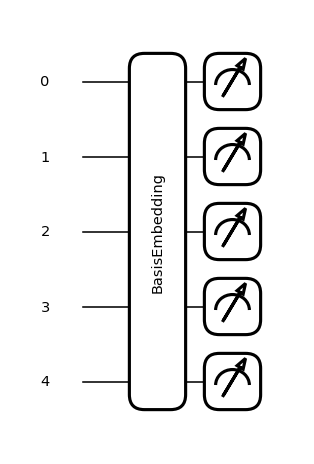

In [46]:
@qml.qnode(dev)
def coding_node(bits, n_qubits=5):
    BasisEmbedding(bits, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

coding_node([0, 1, 1, 0, 0])
qml.draw_mpl(coding_node)([0, 1, 1, 0, 0])

Представление массива битовых строк. Для их представления необходим препроцессинг -- преобразование битовых строк в коэффициенты при базисных состояниях. Если базисное состояние соответствует строке, то она включается в состояние с амплитудой $1/\sqrt{M}$, иначе не включается.

При таком способе представления удобно использовать класс **QubitStateVector**, который принимает на вход амплитуды базисных состояний и генерирует на выходе состояние с заданными амплитудами.

In [47]:
@qml.qnode(dev)
def coding_node(bits_data, n_qubits=5):
    QubitStateVector(bits_data, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))


def preprocess_data(bits_data):
    str_data = [str(b) for b in bits_data]
    basis = [str(np.tensor(i)) for i in itertools.product([0, 1], repeat=len(bits_data[0]))]
    weights = []
    for b in basis:
        weights.append(int(b in str_data) / np.sqrt(len(bits_data) - 1))
    return np.array(weights)

Создадим набор случайных битовых строк и преобразуем его в амплитуды

In [48]:
N = n_qubits
M = 10
initial_data = [np.random.randint(2, size=5) for i in range(M)]
initial_data = list(filter(lambda b: (int(sum(b)) < N) & (int(sum(b)) > 0), initial_data))
basis_data = preprocess_data(initial_data)
[str(b) for b in initial_data]

['[1 0 1 0 1]',
 '[0 0 0 1 0]',
 '[1 1 0 0 1]',
 '[1 1 0 1 1]',
 '[1 0 0 1 1]',
 '[0 0 1 1 0]',
 '[1 0 1 0 0]',
 '[0 0 1 0 1]',
 '[0 0 1 0 0]',
 '[1 1 1 1 0]']

In [49]:
print(basis_data)

[0.         0.         0.33333333 0.         0.33333333 0.33333333
 0.33333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.33333333 0.33333333 0.33333333 0.         0.
 0.         0.33333333 0.         0.33333333 0.         0.
 0.33333333 0.        ]


Посмотрим на сгенерированную схему

(<Figure size 300x450 with 1 Axes>, <Axes:>)

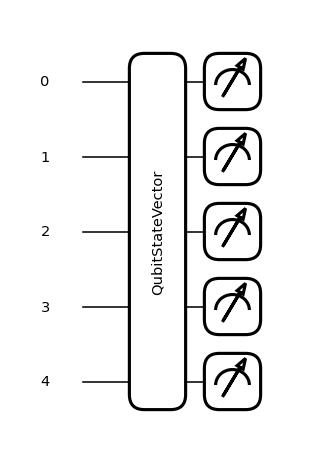

In [50]:
coding_node(basis_data / np.sqrt(np.sum(basis_data ** 2)))
qml.draw_mpl(coding_node)([0, 1, 1, 0, 0])

### Amplitude embedding
Классические данные -- набор векторов ($x_m\in\mathbb{R}^N$) с целыми или действительными числами. Для представления данных в квантовом виде их выстраивают в одномерный массив $\{x_{m,n}:m=1,\dots,M,n=1,\dots,N\}\to\{x_k:k=m + n=1,\dots,M\cdot N\}$. Массив нормируют на единицу и передают в качестве параметров в квантовую схему, состояние на выходе которой имеет вид:

$$ |X\rangle = \sum_{k=1}^{M\cdot N} x_k|k\rangle $$

Здесь $|k\rangle$ -- базисное состояние в вычислительном базисе. Для представления $M$ векторов размерности $N$ необходимо как минимум $n=\log_2{(MN)}$ кубитов. Если $MN\neq 2^n,n\in\mathbb{N}$, то исходные данные дополняются "неинформативными" константами, например нулями.

В **pennylane** для представления данных в амплитуды есть класс **AmplitudeEmbedding**. Сгенерируем случайные векторные данные. У нас есть 5 кубитов, поэтому $NM\leq 32$.

In [57]:
N = 4
M = 2 ** n_qubits // N
initial_data = [np.random.random_sample((N,)) for i in range(M)]
initial_data

[tensor([0.57613408, 0.82106884, 0.42678237, 0.03268671], requires_grad=True),
 tensor([0.69214984, 0.58050236, 0.95143547, 0.83765365], requires_grad=True),
 tensor([0.25311358, 0.48461725, 0.25128472, 0.93991254], requires_grad=True),
 tensor([0.33407907, 0.62533383, 0.26516814, 0.96780024], requires_grad=True),
 tensor([0.91604292, 0.07289207, 0.0318917 , 0.15697051], requires_grad=True),
 tensor([0.49430749, 0.29994308, 0.16003372, 0.27783062], requires_grad=True),
 tensor([0.95733021, 0.47740421, 0.65260603, 0.50466952], requires_grad=True),
 tensor([0.1284431 , 0.50134604, 0.0282463 , 0.18290618], requires_grad=True)]

In [58]:
@qml.qnode(dev)
def coding_node(data, n_qubits=5):
    AmplitudeEmbedding(features=data, wires=range(n_qubits), normalize=True)
    return qml.probs(wires=range(n_qubits))

(<Figure size 300x450 with 1 Axes>, <Axes:>)

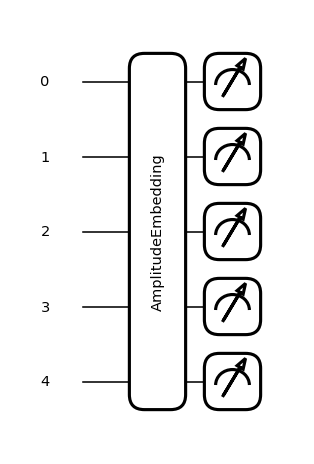

In [59]:
amplitude_data = np.concatenate(initial_data)
coding_node(amplitude_data)
qml.draw_mpl(coding_node)([0, 1, 1, 0] * 8)

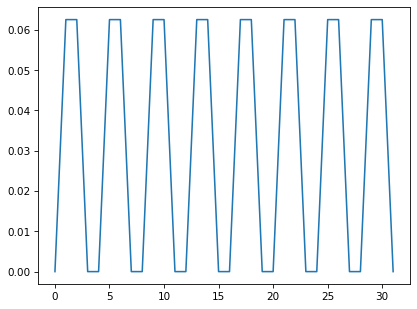

In [65]:
plt.plot(coding_node([0, 1, 1, 0] * 8))

### Angle embedding
Еще один "простой" тип представления. Классические данные -- набор чисел $X=\{x_1,\dots,x_M\}\in\mathbb{R}^M$, и каждое число сопоставляется повороту кубита вокруг одной из трех осей. Например, при повороте вокруг оси $x$, состояние на выходе кодирующей схемы имеет вид:

$$ |X\rangle = \prod_{k=1}^M r_x(x_k)|0_k\rangle$$
Где $|0_k\rangle$ -- основное состояние $k$-го кубита. Для внедрения $M$ числе необходимо как минимум $n=M$ кубитов.

Для этого представления в **pennylane** есть класс **AngleEmbedding**. Создадим набор случайных чисел размерности $M=5$

In [54]:
M = n_qubits
initial_data = np.random.random_sample((M,))
initial_data

tensor([0.95736613, 0.66624775, 0.48760098, 0.43683994, 0.16305666], requires_grad=True)

In [68]:
@qml.qnode(dev)
def coding_node(data, n_qubits=5):
    AngleEmbedding(features=data, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

(<Figure size 300x450 with 1 Axes>, <Axes:>)

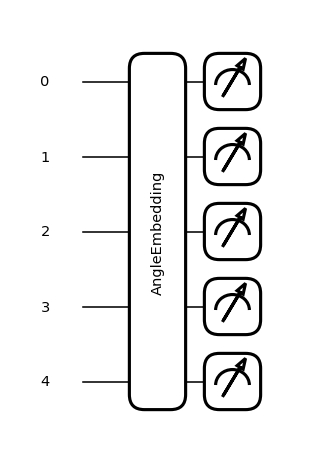

In [71]:
coding_node(initial_data)
qml.draw_mpl(coding_node)([0, 1, 1, 0, 0])

In [74]:
coding_node([1])

tensor([0.77015115, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.22984885, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ], requires_grad=True)